## Project 5: Vehicle Detection
### Author: Tri Minh Cao
### Email: trimcao@gmail.com
### Date: July 2017

#### Tasks
- Obtain HOG and color features for the training data. 
    - Need to choose color and channel that work best (need to experiment)
    - Split data into training and validation set
- Train a SVM classifier
    - Use RandomSearch to find the best parameters for the classifier.
    - For other parameters (related to features), need to do my own experiments.
- Sliding window
    - Multi-scale window (various sizes for each part of the road)
- HOG sub-sampling window search
- Heat map to avoid false positives
    - Find the centroid of multiple windows (in case of multiple true positives).

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,7]

### Lesson Functions

In [3]:
def color_hist(img, nbins=32, bins_range=(0,1)):
    """
    Compute the histogram of color channels separately.
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    """
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate to create a feature vector
    hist_features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    return hist_features

In [4]:
def bin_spatial(img, size=(32,32)):
    """
    Compute binned color features. 
    """
    small_img = cv2.resize(img, size)
    features = small_img.ravel()
    return features

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Get HOG features from an image.
    """
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)   
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                       cells_per_block=(cell_per_block,cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [23]:
def single_img_features(image, color_space='RGB', spatial_size=(32,32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract spatial, color histogram, and HOG features for a single image.
    """
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    # start obtaining features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            # ravel the feature list
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

In [33]:
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract spatial, color histogram, and HOG features from images.
    """
    # Create a list of feature vectors
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # read image file
        image = mpimg.imread(file)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_features = single_img_features(image, color_space, spatial_size,
                                           hist_bins, orient, pix_per_cell,
                                           cell_per_block, hog_channel,
                                           spatial_feat, hist_feat, hog_feat)  
        features.append(img_features)
    return features

In [7]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    """
    Draw bounding boxes.
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    

In [8]:
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None,None],
                 xy_window=(64,64), xy_overlap=(0.5,0.5)):
    """
    Sliding a window and obtain an image for each window.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Obtain image data

In [25]:
os.listdir('./vehicles/')

['.DS_Store',
 'GTI_Far',
 'GTI_Left',
 'GTI_MiddleClose',
 'GTI_Right',
 'KITTI_extracted']

In [26]:
def get_image_path(path):
    """
    Get all images path from a folder.
    Note that the actual images reside in *one* more folder layer.
    """
    paths = os.listdir(path)
    images = []
    for each in paths:
        cur_path = path + each + '/'
        images.extend(glob.glob(cur_path + '*.png'))
    return images

In [27]:
# Get the list of image paths
cars = get_image_path('./vehicles/')
notcars = get_image_path('./non-vehicles/')

In [28]:
print(cars[0])

./vehicles/GTI_Far/image0000.png


### Train a classifier

In [60]:
# parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations (default 9)
pix_per_cell = 10 # HOG pixels per cell (default 8)
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions (default 32, 32)
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

y_start_stop = [400,700] # Min and max in y to search in slide_window()

In [56]:
test_cars = cars[:2]
test_features = extract_features(test_cars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat, hist_feat,
                                hog_feat)
print(len(test_features[0]))

5964


/Users/trimcao/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [61]:
# Extracting features
car_features = extract_features(cars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat, hist_feat,
                                hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins,
                                   orient, pix_per_cell, cell_per_block,
                                   hog_channel, spatial_feat, hist_feat,
                                   hog_feat)

/Users/trimcao/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [62]:
# Create train and test sets  

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [67]:
c_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
for c in c_values:
    print('current C=', c)
    svc = LinearSVC(C=c)
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print()

current C= 0.2
15.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.4
15.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.6
25.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.8
20.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.0
24.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.2
11.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.4
9.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.6
18.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.8
9.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 2.0
9.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9904



In [68]:
# Train a classifier

# Use a linear SVC 
svc = LinearSVC()
# svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

12.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


In [69]:
filename = 'classifier_071917.pkl'

In [70]:
# Save the classifier 
# need to save svc, X_scaler
save = (svc, X_scaler)
pickle.dump(save, open(filename, 'wb'))

### Checkpoint: Load the trained classifier

In [41]:
svc, X_scaler = pickle.load( open( filename, "rb" ) )

### Sliding window search

In [18]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/Users/trimcao/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


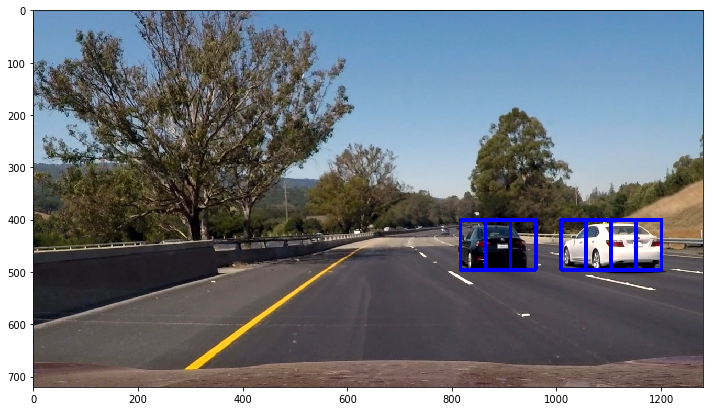

In [19]:
# test search windows
image = cv2.imread('./test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

plt.rcParams["figure.figsize"] = [12,7]
plt.imshow(window_img)


### Heatmap from detection

In [100]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img

### Pipeline to detect cars (with HOG Sub-sampling)

In [72]:
# TODO: refactor the pipeline code, split it into multiple functions

# rewrite search_windows function
# add heatmap() function

In [88]:
def heatmap_labels(img, box_list, threshold=1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels, heatmap

In [85]:
def detect_cars(frame, scale, pix_per_cell, cell_per_block,
                orient):
    imshape = frame.shape
    frame = cv2.resize(frame, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = frame[:,:,0]
    ch2 = frame[:,:,1]
    ch3 = frame[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(frame[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # we got a hot window
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

In [79]:
# More parameters
ystart = 400
ystop = 656
scales = [1., 1.5, 2.]

In [101]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=400, ystop=650, scales=scales, svc=svc, X_scaler=X_scaler,
              orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
              spatial_size=spatial_size, hist_bins=hist_bins, heat_threshold=1,
              heatmap_show=False): 
    draw_img = np.copy(img)
    # print(img)
    # scale back to [0..1] range (because that's the range we use in training)
    img = img.astype(np.float32)/255   
    img_tosearch = img[ystart:ystop,:,:]
    # convert color space to YCrCb
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    # save the hot windows in box_list list
    box_list = []
    for scale in scales:
        box_list.extend(detect_cars(ctrans_tosearch, scale, pix_per_cell, cell_per_block,
                               orient))
    
    # threshold using heatmap
    labels, heatmap = heatmap_labels(img, box_list, threshold=1)
    # draw the labels on the original image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = draw_img * 255
    if heatmap_show:
        return draw_img, heatmap
    return draw_img

[[[ 48  57  64]
  [ 36  46  55]
  [ 33  45  57]
  ..., 
  [181 182 186]
  [215 211 208]
  [248 241 235]]

 [[ 29  47  61]
  [ 21  40  55]
  [ 62  83 100]
  ..., 
  [137 153 166]
  [155 164 173]
  [192 197 203]]

 [[ 11  41  65]
  [ 74 106 129]
  [125 159 186]
  ..., 
  [124 155 183]
  [132 158 181]
  [136 158 179]]

 ..., 
 [[ 75  65  64]
  [ 99  87  87]
  [100  88  88]
  ..., 
  [ 94  77  70]
  [106  89  82]
  [142 125 118]]

 [[ 65  55  54]
  [104  92  92]
  [107  95  95]
  ..., 
  [ 82  64  60]
  [101  83  79]
  [133 118 113]]

 [[ 34  24  23]
  [ 78  68  67]
  [112 100 100]
  ..., 
  [ 75  57  53]
  [116 101  96]
  [149 134 129]]]


/Users/trimcao/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


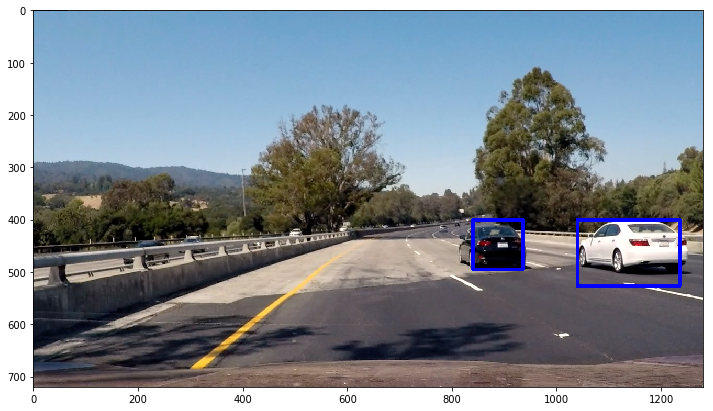

In [93]:
# test HOG sub-sampling
img = mpimg.imread('./test_images/test4.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
scales = [1., 1.5, 2.]
# scales = [2]
out_img, heatmap = find_cars(img, ystart, ystop, scales, svc, X_scaler,
                             orient, pix_per_cell, cell_per_block,
                             spatial_size, hist_bins, heat_threshold=1, heatmap_show=True)
plt.imshow(out_img)
# plt.imshow(heatmap)

In [105]:
# Quick test on a video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set the video output and input
output = './output/project5_test.mp4'
# output = 'output/project4_text_short.mp4'
# origin_clip = VideoFileClip('./project_video.mp4').subclip(20,35)
origin_clip = VideoFileClip('./project_video.mp4')
drawn_clip = origin_clip.fl_image(find_cars)
%time drawn_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output/project5_test.mp4
[MoviePy] Writing video ./output/project5_test.mp4



 12%|█▏        | 152/1261 [03:01<21:08,  1.14s/it]


 24%|██▍       | 303/1261 [06:23<21:45,  1.36s/it]


 36%|███▌      | 454/1261 [09:27<15:16,  1.14s/it]


 48%|████▊     | 605/1261 [12:32<16:22,  1.50s/it]


 60%|█████▉    | 756/1261 [15:48<09:47,  1.16s/it]


 72%|███████▏  | 907/1261 [18:45<06:02,  1.02s/it]


 84%|████████▍ | 1057/1261 [21:26<03:39,  1.08s/it]


 96%|█████████▌| 1205/1261 [24:08<01:05,  1.16s/it]


100%|█████████▉| 1260/1261 [25:08<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/project5_test.mp4 

CPU times: user 22min 52s, sys: 1min 23s, total: 24min 16s
Wall time: 25min 10s
